In [1]:
import torch 

In [4]:
x = torch.tensor([[12.9382, 11.2081, 11.0942],
        [12.9211, 11.1199, 11.0261],
        [14.3441, 13.3287, 12.6234],
        [13.7739, 13.2769, 12.5926]], device='cuda:0')

In [20]:
p = torch.cumsum(x / x.sum(dim=-1, keepdim=True), dim=-1)

In [51]:
idx = torch.searchsorted(p, torch.rand([p.shape[0], 1]).to("cuda:0"))

In [52]:
idx

tensor([[2],
        [0],
        [1],
        [1]], device='cuda:0')

In [53]:
idx.shape

torch.Size([4, 1])

In [54]:
x.shape

torch.Size([4, 3])

In [56]:
x.gather(dim=1, index=idx)

tensor([[11.0942],
        [12.9211],
        [13.3287],
        [13.2769]], device='cuda:0')

In [ ]:
torch.stack([torch.cat([xi[:bpi], e, xi[bpi:]]) for xi, bpi in zip(x, bp)])

In [65]:
x= torch.tensor([[6031, 6031, 6031, 6047],
        [6031, 6031, 6031, 6046],
        [6047, 6047, 6047, 6046],
        [6046, 6046, 6046, 6012],
        [6046, 6046, 6046, 6013],
        [6012, 6012, 6012, 6008],
        [6013, 6013, 6013, 6031],
        [6008, 6008, 6008, 6031],
        [6031, 6031, 6031, 6031],
        [6031, 6031, 6031, 6046],
        [   0, 6031, 6031, 6046],
        [   0,    0, 6046,    0]], device='cuda:0')

pred_loc= torch.tensor([[6031],
        [6033],
        [6031],
        [6031]], device='cuda:0')

In [63]:
x.shape

torch.Size([12, 4])

In [80]:
x_after = torch.tensor([[6031, 6031, 6031, 6047],
        [6031, 6031, 6031, 6046],
        [6047, 6047, 6047, 6046],
        [6046, 6046, 6046, 6012],
        [6046, 6046, 6046, 6013],
        [6012, 6012, 6012, 6008],
        [6013, 6013, 6013, 6031],
        [6008, 6008, 6008, 6031],
        [6031, 6031, 6031, 6031],
        [6031, 6031, 6031, 6046],
        [6031, 6031, 6031, 6046],
        [   0, 6033, 6046, 6031],
        [   0,    0, 6031,    0]], device='cuda:0')
x_len_before = torch.tensor([9, 10, 11, 10], device='cuda:0')
x_len_after = torch.tensor([11, 12, 13, 12], device='cuda:0')

In [85]:
x_after

tensor([[6031, 6031, 6031, 6047],
        [6031, 6031, 6031, 6046],
        [6047, 6047, 6047, 6046],
        [6046, 6046, 6046, 6012],
        [6046, 6046, 6046, 6013],
        [6012, 6012, 6012, 6008],
        [6013, 6013, 6013, 6031],
        [6008, 6008, 6008, 6031],
        [6031, 6031, 6031, 6031],
        [6031, 6031, 6031, 6046],
        [6031, 6031, 6031, 6046],
        [   0, 6033, 6046, 6031],
        [   0,    0, 6031,    0]], device='cuda:0')

In [98]:
gen = torch.stack([xi[x_len_beforei:x_len_afteri] for xi, x_len_beforei, x_len_afteri in zip(x_after.transpose(1, 0), x_len_before, x_len_after)])

In [99]:
gen

tensor([[6031, 6031],
        [6031, 6033],
        [6046, 6031],
        [6046, 6031]], device='cuda:0')

In [101]:
torch.cat([gen, gen], dim=0)

tensor([[6031, 6031],
        [6031, 6033],
        [6046, 6031],
        [6046, 6031],
        [6031, 6031],
        [6031, 6033],
        [6046, 6031],
        [6046, 6031]], device='cuda:0')

In [86]:
for xi, x_len_beforei, x_len_afteri in zip(x_after.transpose(1, 0), x_len_before, x_len_after):
    print(xi, x_len_beforei, x_len_afteri)
    print(xi[x_len_beforei:x_len_afteri])
    break

tensor([6031, 6031, 6047, 6046, 6046, 6012, 6013, 6008, 6031, 6031, 6031,    0,
           0], device='cuda:0') tensor(9, device='cuda:0') tensor(11, device='cuda:0')
tensor([6031, 6031], device='cuda:0')


## Validation


In [28]:
import os
import pandas as pd
import geopandas as gpd

from loc_predict.processing import _split_train_test
from utils.utils import load_data
from shapely import wkt

import powerlaw
import matplotlib.pyplot as plt

from metrics.metrics import radius_gyration, jump_length, location_frquency, wait_time

In [29]:
data_dir = os.path.join("data", "validation")
# read and preprocess
sp = pd.read_csv(os.path.join(data_dir, "sp.csv"), index_col="id")
loc = pd.read_csv(os.path.join(data_dir, "locs_s2.csv"), index_col="id")
sp = load_data(sp, loc)

train_data, vali_data, test_data = _split_train_test(sp)

test_data = test_data.merge(
    loc.reset_index()[["id", "center"]].rename(columns={"id": "location_id"}), how="left", on="location_id"
)
test_data.rename(columns={"center": "geometry"}, inplace=True)
test_data["geometry"] = test_data["geometry"].apply(wkt.loads)
test_data = gpd.GeoDataFrame(test_data, geometry="geometry", crs="EPSG:4326")


In [30]:
test_data

,id,user_id,started_at,finished_at,duration,location_id,start_day,start_min,weekday,geometry
0,195,1,2019-12-17 07:10:07.921999,2019-12-17 07:17:54.010999,420.0,6031,69,430,1,POINT (6.83931 46.85233)
1,196,1,2019-12-19 06:54:48.288000,2019-12-19 07:29:01.704999,2040.0,6031,71,414,3,POINT (6.83931 46.85233)
2,197,1,2019-12-19 07:38:43.802999,2019-12-19 10:19:20.016999,2879.0,6031,71,458,3,POINT (6.83931 46.85233)
3,198,1,2019-12-19 10:33:50.572999,2019-12-19 10:49:12.854000,900.0,6046,71,633,3,POINT (7.50002 47.42270)
4,199,1,2019-12-19 10:59:08.976999,2019-12-19 11:59:07.772000,2879.0,6046,71,659,3,POINT (7.50002 47.42270)
...,...,...,...,...,...,...,...,...,...,...
246048,1197148,2094,2019-10-31 12:56:17.243000,2019-10-31 14:05:07.789000,2879.0,4834,55,776,3,POINT (8.54356 47.40027)
246049,1197149,2094,2019-10-31 15:26:16.467000,2019-10-31 17:07:26.619999,2879.0,7402,55,926,3,POINT (8.57121 47.40375)
246050,1197150,2094,2019-10-31 19:22:37.476999,2019-11-01 07:45:05.378999,2879.0,7402,55,1162,3,POINT (8.57121 47.40375)
246051,1197151,2094,2019-11-01 07:51:34.239000,2019-11-01 09:09:36.236000,2879.0,7402,56,471,4,POINT (8.57121 47.40375)


In [31]:
metric = jump_length(test_data)

In [32]:
xlabel = "$\Delta r\,(m)$"
ylabel = "$P(\Delta r)$"
xmin = 1

In [33]:
metric = metric[metric>xmin]

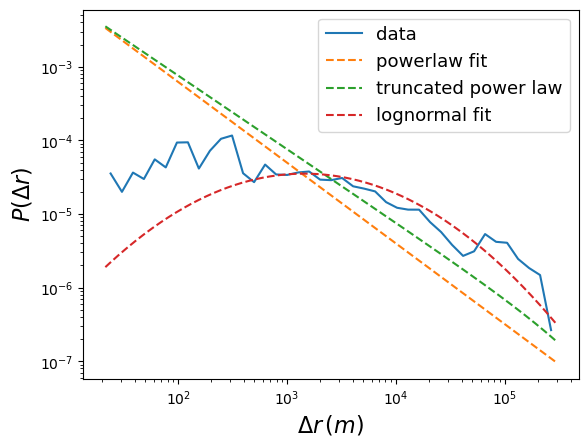

In [34]:
# fit power law
fit = powerlaw.Fit(metric, xmin=xmin)

# plotting
powerlaw.plot_pdf(metric, label="data")
fit.power_law.plot_pdf(linestyle="--", label="powerlaw fit")
fit.truncated_power_law.plot_pdf(linestyle="--", label="truncated power law")
fit.lognormal.plot_pdf(linestyle="--", label="lognormal fit")

plt.legend(prop={"size": 13})
plt.xlabel(xlabel, fontsize=16)
plt.ylabel(ylabel, fontsize=16)

plt.show()

In [46]:
simulated_sp = pd.read_csv(os.path.join(data_dir, "mobis_mhsa_generation.csv"))
simulated_sp

,seq_id,user_id,generated_ls
0,0,1,10302
1,0,1,10311
2,0,1,10301
3,0,1,10350
4,0,1,10350
...,...,...,...
9241645,184832,2094,7912
9241646,184832,2094,13156
9241647,184832,2094,13154
9241648,184832,2094,13153


In [47]:
simulated_sp = simulated_sp.merge(
    loc.reset_index()[["id", "center"]].rename(columns={"id": "location_id"}), how="left", left_on="generated_ls", right_on="location_id"
)

In [48]:
simulated_sp.rename(columns={"center": "geometry"}, inplace=True)
simulated_sp["geometry"] = simulated_sp["geometry"].apply(wkt.loads)
simulated_sp = gpd.GeoDataFrame(simulated_sp, geometry="geometry", crs="EPSG:4326")

In [ ]:
simulated_sp.drop(columns={"user_id", "generated_ls"}, inplace=True)
simulated_sp.rename(columns={"seq_id": "user_id"}, inplace=True)

In [ ]:
simulated_jl = jump_length(simulated_sp)

In [44]:
xlabel = "$\Delta r\,(m)$"
ylabel = "$P(\Delta r)$"
xmin = 1
simulated_jl = simulated_jl[simulated_jl>xmin]

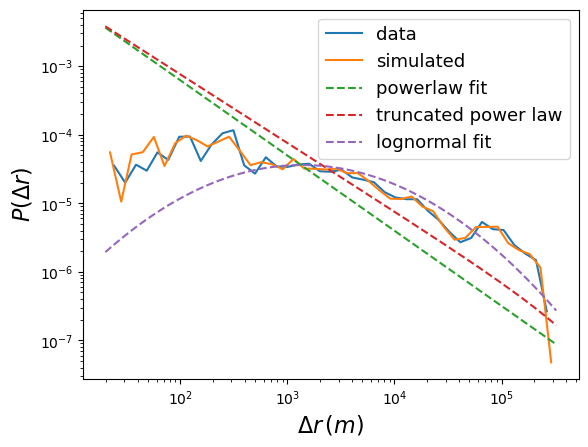

In [45]:
# fit power law
# fit = powerlaw.Fit(simulated_jl, xmin=xmin)

# plotting
powerlaw.plot_pdf(metric, label="data")
powerlaw.plot_pdf(simulated_jl, label="simulated")

# fit.power_law.plot_pdf(linestyle="--", label="powerlaw fit")
# fit.truncated_power_law.plot_pdf(linestyle="--", label="truncated power law")
# fit.lognormal.plot_pdf(linestyle="--", label="lognormal fit")

plt.legend(prop={"size": 13})
plt.xlabel(xlabel, fontsize=16)
plt.ylabel(ylabel, fontsize=16)

plt.show()